<a href="https://colab.research.google.com/github/alecseiterr/Tetrabot/blob/main/Andrey_Novikov/002_notebooks/tetrabot_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Установим необходимые библиотеки
!pip install vosk pydub
!apt-get update
!apt-get install portaudio19-dev
!pip install vosk pydub pyaudio
!dpkg -s libasound2-dev
!pip install ffmpeg-python
!pip install levenshtein

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 44.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 17.7 MB/s eta 0:00:00
  Created wheel for srt: filename=srt-3.5.3-py3-none-any.whl size=22429 sha256=608e92e86db21d21e86acf86e116f31bf867d09d9ad4c7bd2556a1b417ca7cdb
  Stored in directory: /root/.cache/pip/wheels/d7/31/a1/18e1e7e8bfdafd19e6803d7eb919b563dd11de380e4304e332
Successfully built srt
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [555 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:7 https://ppa.launchpadcontent.

In [2]:
# Загрузим необходимые модули и библиотеки
import os
import sys
import json
from pydub import AudioSegment
from vosk import Model, KaldiRecognizer
from google.colab import drive
import shutil
from Levenshtein import distance, editops
import pyaudio
import wave
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg

In [3]:
# Примонтируем Google Drive
drive.mount('/content/drive')

Mounted at /content/drive



*   Скачаем малую модель vosk-model-small-ru-0.22 со страницы https://alphacephei.com/vosk/models
*   Загрузим малую модель в папку /content/drive/MyDrive/AI_data/tetrabot/models
*   Распакуем малую модель с помощью кода, приведенного ниже в папку /content/model

In [4]:
zip_file = '/content/drive/MyDrive/AI_data/tetrabot/models/vosk-model-small-ru-0.22.zip'
extract_dir = '/content/model'
shutil.unpack_archive(zip_file, extract_dir)

In [5]:
# Укажем путь к модели
vosk_model_path = "/content/model/vosk-model-small-ru-0.22"

# Загрузим модель
vosk_model = Model(vosk_model_path)

# Создадим экземпляр распознавателя голоса с помощью модели Vosk
recognizer = KaldiRecognizer(vosk_model, 16000)

Воспользуемся таблицами 1 и 2 из документа "Концепция голосового управления роботом" для формирования словаря

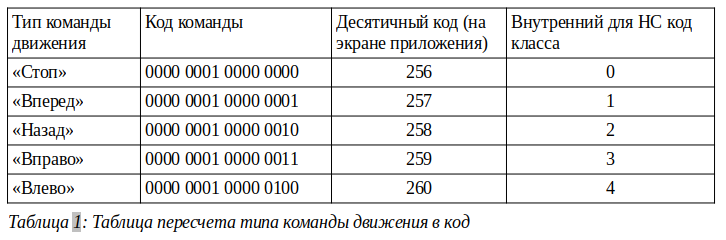

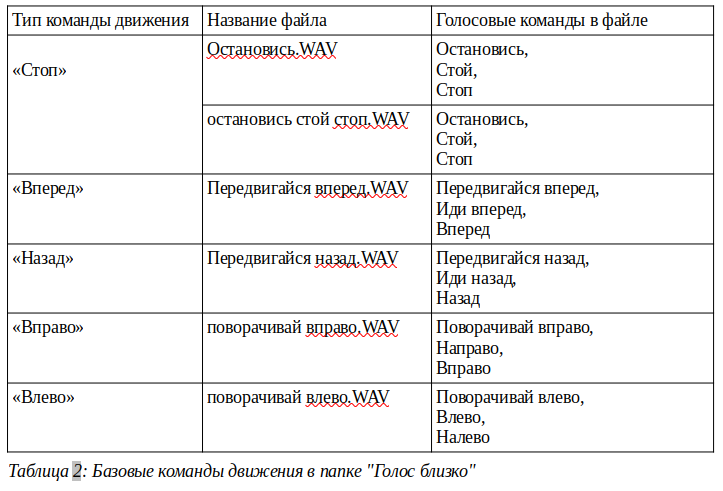

In [14]:
# Создадим словарь joining_dict для 5-ти базовых команд
# В качестве ключей используются различные распознанные слова и фразы
# В качестве значений вводятся однозначно связанные с распознанными словами и фразами команды и десятичный коды
# Команды и десятичные коды задаются в виде кортежа
# Эти же фразы
joining_dict = {'остановись': ('Стоп', 256),
                'стой': ('Стоп', 256),
                'стоп': ('Стоп', 256),
                'передвигайся вперед': ('Вперед', 257),
                'иди вперед': ('Вперед', 257),
                'вперед': ('Вперед', 257),
                'передвигайся назад': ('Назад', 258),
                'иди назад': ('Назад', 258),
                'назад': ('Назад', 258),
                'поворачивай вправо': ('Вправо', 259),
                'направо': ('Вправо', 259),
                'вправо': ('Вправо', 259),
                'поворачивай влево': ('Влево', 260),
                'влево': ('Влево', 260),
                'налево': ('Влево', 260)
}

In [15]:
# Дополнительно (бонусом) заполним значения словаря joining_dict задавая пару ключ-значение для фраз, неизвестных модели Vosk для русского языка
# Ключ вводится в виде после этапов распознавания и вычисления наиболее близкого значения методом наименьшего расстояния Левинштейна,
# т.е. ключ = конечной текстовой команде
# Пример:
new_key = 'вингардиум левиоса'
new_value = ('Зависни', 280)
joining_dict[new_key] = new_value

# Повторяем этот этап пока не будут внесены все значения команд и их кодов
# Эта же конструкция может быть использована в качестве основы для заполнения словаря автоматически из приложения Android

# Другие фразы из числа неизвестных модели Vosk для русского языка
'''
'экспилиармус',
'вингардиум левиоса',
'алохомора',
'экспекто патронум',
'авада кедавра',
'петрификус тоталус'
'''

"\n'экспилиармус',\n'вингардиум левиоса',\n'алохомора',\n'экспекто патронум',\n'авада кедавра',\n'петрификус тоталус'\n"

In [16]:
# Выведем на экран все зарегистрированные команды и двоичные коды для проверки
for command_phrase in joining_dict.keys():
  binary_code = bin(joining_dict.get(command_phrase)[1])
  print('Команда {0:25} : Двоичный код {1:15}'.format(command_phrase, binary_code))

Команда остановись                : Двоичный код 0b100000000    
Команда стой                      : Двоичный код 0b100000000    
Команда стоп                      : Двоичный код 0b100000000    
Команда передвигайся вперед       : Двоичный код 0b100000001    
Команда иди вперед                : Двоичный код 0b100000001    
Команда вперед                    : Двоичный код 0b100000001    
Команда передвигайся назад        : Двоичный код 0b100000010    
Команда иди назад                 : Двоичный код 0b100000010    
Команда назад                     : Двоичный код 0b100000010    
Команда поворачивай вправо        : Двоичный код 0b100000011    
Команда направо                   : Двоичный код 0b100000011    
Команда вправо                    : Двоичный код 0b100000011    
Команда поворачивай влево         : Двоичный код 0b100000100    
Команда влево                     : Двоичный код 0b100000100    
Команда налево                    : Двоичный код 0b100000100    
Команда вингардиум левиос

#### Java-скрипт необходимый для записи голоса с микрофона

In [20]:
AUDIO_HTML = """
<script>                                                      // создаем тег <script>, сообщающий браузеру о том, что внутри находится исполняемый код JavaScript
var my_div = document.createElement("DIV");                   // создаем новый элемент DIV(тег-контейнер для логического выделения блока документа)
var my_p = document.createElement("P");                       // создаем новый элемент P(параграф для логической группировки текста)
var my_btn = document.createElement("BUTTON");                // создаем новый элемент(кнопку) BUTTON
var t = document.createTextNode("Нажмите старт для записи");  // создаем текстовое содержимое для кнопки

my_btn.appendChild(t);                                        // добавляем текстовое содержимое элементу BUTTON
my_div.appendChild(my_btn);                                   // кнопку с текстом BUTTON добавляем в блок DIV
document.body.appendChild(my_div);                            // добавляем наш блок в элемент <body>("тело", для хранения содержимого веб-страницы)

var base64data = 0;                                           // будем использовать для аудиоданных метод кодирования информации в 64-разрядный код
var reader;                                                   // создаем переменную для чтения файла
var recorder, gumStream;                                      // объявляем переменные для записи данных/потока
var recordButton = my_btn;                                    // создаем переменную для кнопки записи аудио с микрофона

var handleSuccess = function(stream) {                        // объявляем функцию для работы с потоками данных
  gumStream = stream;                                         // создаем переменную для потока
  var options = {
    mimeType : 'audio/webm;codecs=opus'                       // в опциях задаем медиа тип с аудиоформатом и кодеками
  };
  recorder = new MediaRecorder(stream);                       // создаем новый объект MediaRecorder, получающий медиапоток для записи.
                                                              // MediaRecorder - интерфейс MediaStream Recording API представляющий функциональность для простой записи медиа. Создается..
                                                              // ..с использованием MediaRecorder() конструктора.
  recorder.ondataavailable = function(e) {                    // вызываем обработчик dataavailable события, запускаемое по окончанию записи
    var url = URL.createObjectURL(e.data);                    // этим методом создаем DOMString(UTF-16 String), содержащий URL с указанием на объект e.data
    var preview = document.createElement('audio');            // создаем элемент-тег аудио
    preview.controls = true;                                  // активизируем элементы управления
    preview.src = url;                                        // берем в кач-ве исходных данных файл, содержащийся в записанной ранее URL
    document.body.appendChild(preview);                       // добавляем элемент аудио в <body>("тело", для хранения содержимого веб-страницы)

    reader = new FileReader();                                // создаем объект класса FileReader для чтения разных источников данных
    reader.readAsDataURL(e.data);                             // читаем содержимое указанного файла
    reader.onloadend = function() {                           // обработчик события, запускаемого после передачи данных
      base64data = reader.result;                             // записываем прочитанное содержимое в base64data
    }
  };
  recorder.start();  // начало записи медиа
  };

// такой текст будет на кнопке BUTTON во время записи аудио
recordButton.innerText = "Идёт запись... нажмите для остановки";

// запрос разрешения пользователя на доступ к устройству захвата аудио(микрофон), указываем True
navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {                                  // функция опишет действия по завершению записи (после клика мышкой по кнопке "Recording... press to stop")
  if (recorder && recorder.state == "recording") {            // если рекордер находится в процессе записи
      recorder.stop();  // рекордер прерывается
      gumStream.getAudioTracks()[0].stop();                   // отключается запись и доступ к микрофону
      recordButton.innerText = ""    // эта надпись(сохранение записи) отобразится на кнопке BUTTON
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {                                          // создаем функцию с задержкой вызова
  return new Promise(resolve => setTimeout(resolve, ms));

  // new Promise - конструкция для отложенных вычислений
  // setTimeout позволяет вызвать функцию один раз через определённый интервал времени
}

var data = new Promise(resolve=>{
recordButton.onclick = ()=>{      // при нажатии левой кнопкой мыши на кнопку "Recording... press to stop"
toggleRecording()                 // вызывается функция завершения аудиозаписи

sleep(2000).then(() => {          // и после задержки 2000мс(2 сек)
  resolve(base64data.toString())  // полученные данные из формата base64 преобразовываем в строку

});

}
});

</script>
"""

Функции

In [21]:
def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])

  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)

  riff_chunk_size = len(output) - 8
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

In [72]:
# Воспользуемся методом наименьшего расстояния Левинштейна для исправления ошибок
# неизбежных при работе голосового распознавания
# Функция нахождения ближайшего слова в словаре
def find_closest_word(word):
    min_distance = float('inf')
    closest_word = None

    count = 0
    for dict_word in joining_dict.keys():
        dist = distance(word, dict_word)
        if dist < min_distance:
            min_distance = dist
            closest_word = dict_word
            count += 1
    if min_distance > 8:
      return ('Ошибка', 65535)
    else:
      return closest_word

In [23]:
# Функция распознавания голосовых команд через микрофон
def recognize_voice_command_mic():
    # Загрузка аудио через микрофон
    audio, sr = get_audio()
    # Преобразование numpy-массива в объект AudioSegment
    audio_segment = AudioSegment(
                                audio.tobytes(),
                                frame_rate=sr,
                                sample_width=audio.dtype.itemsize,
                                channels=1
                                )
    # Преобразование записи в один канал с частотой дискретизации 16 kHz (требование модели Vosk)
    audio = audio_segment.set_frame_rate(16000).set_channels(1)

    # Распознавание голоса
    results = []
    chunk_size_ms = 4000  # Обработка потока чанками в 4 секунды
    for i in range(0, len(audio), chunk_size_ms):
        chunk = audio[i:i + chunk_size_ms]
        if len(chunk) > 0:
            raw_data = chunk.raw_data
            recognizer.AcceptWaveform(raw_data)
            result = json.loads(recognizer.Result())
            results.append(result)

    # Сборка распознанных фрагментов и вывод на экран
    recognized_text = " ".join(result['text'] for result in results)


    closest_match = find_closest_word(recognized_text)
    try:
        command = joining_dict.get(closest_match)[0]
        binary_code = bin(joining_dict.get(closest_match)[1])
        print('Распознанный текст: {0:25} : Команда {1:25} : Двоичный код {2:15}'.format(closest_match, command, binary_code))
    except Exception as e:
        print(f'Распознанный текст: "{recognized_text}" и ближайшая команда "{closest_match}"')
        print(f'Словари не согласованы. Добавьте команду, соответствующую "{recognized_text}" и двоичный код в словарь "joining_dict"')

In [75]:
recognize_voice_command_mic()

Распознанный текст: вингардиум левиоса        : Команда Зависни                   : Двоичный код 0b100011000    
